code to predict pv generation

In [43]:
import numpy as np
import pandas as pd
from scipy.stats import norm, gamma
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.ticker import MaxNLocator # To ensure demand axis are integer.


from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error


# Third party packages.
import os                       # Execute tasks related to your operating system.

import polars as pl             # Data handling ('Blazingly fast DataFrames') and is a drop-in replacement for pandas.
import pickle                   # Save and load data to and from pickle files.
import time
import json
import os
import joblib

from icecream import ic         # Print variables.
from datetime import datetime


Data Understanding

Load data set. Split with 80% and 20% split

In [44]:
# Load API Key and download directory from config file
CONFIG_FILE = "../config/api-call.json"

def load_config(config_path):
    """Load configuration from a JSON file."""
    with open(config_path, "r") as file:
        return json.load(file)

# Load config values
config = load_config(CONFIG_FILE)

# print(config)
DOWNLOAD_DIR = config["ned"]["ned_download_dir"]
print("DOWNLOAD_DIR :", DOWNLOAD_DIR)
pkl_file_path = f'{DOWNLOAD_DIR}/power-gen-type-0.pkl'

# with open('../data/dc-ned-json-data-1.pkl', 'rb') as pickle_file:
with open(pkl_file_path, 'rb') as pickle_file:
    dc_ned_json_data_1 = pickle.load(pickle_file)

# df_ned_json_data = dc_ned_json_data_1['df_orig']
df_ned_json_data = pd.DataFrame(dc_ned_json_data_1)  # Convert dictionary to DataFrame


# df_ned_json_data = dc_ned_json_data_1['df_orig']
df_ned_json_data = pd.DataFrame(dc_ned_json_data_1)  # Convert dictionary to DataFrame

df_pd_orig = df_ned_json_data
# Show a sample of first 3 rows.
df_pd_orig.head(3)


DOWNLOAD_DIR : ../data/powergen/


,@id,@type,id,point,type,granularity,granularitytimezone,activity,classification,capacity,volume,percentage,emission,emissionfactor,validfrom,validto,lastupdate
0,/v1/utilizations/23791261744,Utilization,23791261744,/v1/points/0,/v1/types/0,/v1/granularities/4,/v1/granularity_time_zones/0,/v1/activities/1,/v1/classifications/2,8134680,2033670,0,0,0,2021-12-31T23:00:00+00:00,2021-12-31T23:15:00+00:00,2024-11-10T19:01:35+00:00
1,/v1/utilizations/23791591475,Utilization,23791591475,/v1/points/0,/v1/types/0,/v1/granularities/4,/v1/granularity_time_zones/0,/v1/activities/1,/v1/classifications/2,8039900,2009975,0,0,0,2021-12-31T23:15:00+00:00,2021-12-31T23:30:00+00:00,2024-11-10T19:01:35+00:00
2,/v1/utilizations/23792244041,Utilization,23792244041,/v1/points/0,/v1/types/0,/v1/granularities/4,/v1/granularity_time_zones/0,/v1/activities/1,/v1/classifications/2,8128668,2032167,0,0,0,2021-12-31T23:30:00+00:00,2021-12-31T23:45:00+00:00,2024-11-10T19:01:35+00:00


Descriptive Statistics

In [45]:
# Using Pandas.
df_pd_num = df_pd_orig.select_dtypes(include='number')

# Column names (Pandas: df_pd_orig_num.columns.tolist()).
l_df_num_names = df_pd_num.columns
print(f"We have {len(l_df_num_names)} numerical variables:\n{l_df_num_names}")

# Convert to datetime format
df_pd_orig_str    = df_pd_orig.select_dtypes(include='object')
print("Number of rows:", df_pd_orig_str.shape[0], "and column names are:", df_pd_orig_str.columns, "and column types are:", df_pd_orig_str.dtypes)

We have 6 numerical variables:
Index(['id', 'capacity', 'volume', 'percentage', 'emission', 'emissionfactor'], dtype='object')
Number of rows: 34944 and column names are: Index(['@id', '@type', 'point', 'type', 'granularity', 'granularitytimezone',
       'activity', 'classification', 'validfrom', 'validto', 'lastupdate'],
      dtype='object') and column types are: @id                    object
@type                  object
point                  object
type                   object
granularity            object
granularitytimezone    object
activity               object
classification         object
validfrom              object
validto                object
lastupdate             object
dtype: object


To check if the output column has unique values

In [46]:
l_col = ['capacity']

for s_col in l_col:
    print(f"{l_col}: {df_pd_orig[l_col]}")
    print(f"{s_col}: {df_pd_orig[s_col].unique()}")

['capacity']:        capacity
0       8134680
1       8039900
2       8128668
3       8090804
4       8101220
...         ...
34939  12094504
34940  12053024
34941  12010416
34942  11933236
34943  11862020

[34944 rows x 1 columns]
capacity: [ 8134680  8039900  8128668 ... 12010416 11933236 11862020]


Contruct a descriptive summary

In [47]:
df_pd_orig.describe()

,id,capacity,volume,percentage,emission,emissionfactor
count,3.494400e+04,3.494400e+04,3.494400e+04,34944.0,34944.0,34944.0
mean,3.763316e+10,9.217292e+06,2.304323e+06,0.0,0.0,0.0
std,7.989161e+09,3.884491e+06,9.711227e+05,0.0,0.0,0.0
min,2.379126e+10,3.050108e+06,7.625270e+05,0.0,0.0,0.0
25%,3.072638e+10,5.972254e+06,1.493064e+06,0.0,0.0,0.0
50%,3.764883e+10,8.605130e+06,2.151282e+06,0.0,0.0,0.0
75%,4.457940e+10,1.195338e+07,2.988344e+06,0.0,0.0,0.0
max,5.152906e+10,2.204448e+07,5.511119e+06,0.0,0.0,0.0


Prepare data for prediction

In [48]:
# Step 1: Convert 'validto' column to datetime
df_pd_orig['validto'] = pd.to_datetime(df_pd_orig['validto'])

# Step 2: Sort the DataFrame by 'validto' to avoid data leakage
df = df_pd_orig.sort_values(by='validto')

# Step 3: Split the data into train and test based on time (using a percentage split)
train_size = int(len(df) * 0.8)  # 80% for training
train = df[:train_size].copy()  # Using the first 80% for training
test = df[train_size:].copy()   # Using the last 20% for testing


Use of TImeseries split to avoid data leakage. Then perform prediction using regression models

Mean Absolute Error (MAE): 2583313.6898561884
shape: (6_989, 4)
┌───────────────┬──────────┬───────────┬──────────┐
│ X Values      ┆ Actual   ┆ Predicted ┆ Diff     │
│ ---           ┆ ---      ┆ ---       ┆ ---      │
│ array[i64, 1] ┆ i64      ┆ i64       ┆ i64      │
╞═══════════════╪══════════╪═══════════╪══════════╡
│ [1666152000]  ┆ 5857492  ┆ 8011255   ┆ -2153763 │
│ [1666152900]  ┆ 5932232  ┆ 8011172   ┆ -2078940 │
│ [1666153800]  ┆ 6019340  ┆ 8011088   ┆ -1991748 │
│ [1666154700]  ┆ 6229824  ┆ 8011005   ┆ -1781181 │
│ [1666155600]  ┆ 6350092  ┆ 8010921   ┆ -1660829 │
│ …             ┆ …        ┆ …         ┆ …        │
│ [1672437600]  ┆ 12094504 ┆ 7428161   ┆ 4666343  │
│ [1672438500]  ┆ 12053024 ┆ 7428078   ┆ 4624946  │
│ [1672439400]  ┆ 12010416 ┆ 7427994   ┆ 4582422  │
│ [1672440300]  ┆ 11933236 ┆ 7427911   ┆ 4505325  │
│ [1672441200]  ┆ 11862020 ┆ 7427827   ┆ 4434193  │
└───────────────┴──────────┴───────────┴──────────┘


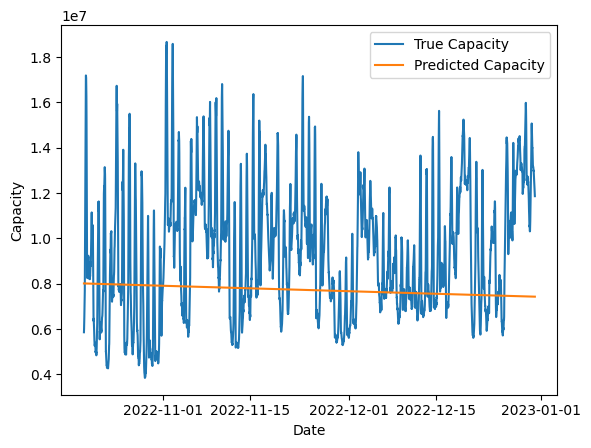

In [ ]:
# Step 4: Convert 'validto' (datetime) to numeric format (Unix timestamp in seconds)
train['validto_numeric'] = train['validto'].astype('int64') // 10**9  # Convert datetime to numeric timestamp
test['validto_numeric'] = test['validto'].astype('int64') // 10**9

# Step 5: Train the Linear Regression model on 'validto_numeric' column only
X_train = train[['validto_numeric']]  # Use 'validto_numeric' as the input
y_train = train['capacity']  # 'capacity' as the target

model = LinearRegression()
model.fit(X_train, y_train)

# Step 6: Make predictions on the test set
X_test = test[['validto_numeric']]
y_test = test['capacity']

predictions = model.predict(X_test)
y_int_pred = np.round(predictions).astype(int)  # Rounds and converts to int

# Step 7: Calculate and print performance metrics (e.g., MAE)
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error (MAE): {mae}")

# Step 7: Convert Predictions Back to Polars (Optional)
df_pred = pl.DataFrame({"X Values": X_test.values, "Actual": y_test.values, "Predicted": y_int_pred, "Diff": y_test.values - y_int_pred})
print(df_pred)



# Step 8: Visualize the results (optional)
plt.plot(test['validto'], y_test, label='True Capacity')
plt.plot(test['validto'], predictions, label='Predicted Capacity')
plt.xlabel('Date')
plt.ylabel('Capacity')
plt.legend()
plt.show()

Predict using LASSO model

In [ ]:
'''
# Train Lasso Regression Model
lasso = Lasso(alpha=0.1)  # Adjust alpha for regularization strength
lasso.fit(X_train, y_train)
# Make Predictions
y_pred = lasso.predict(X_test)
y_int_pred = np.round(y_pred).astype(int)  # Rounds and converts to int

# Evaluate Model
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Step 7: Convert Predictions Back to Polars (Optional)
df_pred = pl.DataFrame({"X Values": X_test.values, "Actual": y_test.values, "Predicted": y_int_pred, "Diff": y_test.values - y_int_pred})
print(df_pred)
'''

Predict using decision tree regression

In [ ]:
'''
# Train Decision Tree Regressor Model
dt_regressor = DecisionTreeRegressor(max_depth=3, random_state=42)
dt_regressor.fit(X_train, y_train)

# Make Predictions
y_pred = dt_regressor.predict(X_test)
y_int_pred = np.round(y_pred).astype(int)  # Rounds and converts to int

# Evaluate Model
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Step 7: Convert Predictions Back to Polars (Optional)
df_pred = pl.DataFrame({"X Values": X_test.values, "Actual": y_test.values, "Predicted": y_int_pred, "Diff": y_test.values - y_int_pred})
print(df_pred)
'''


Predit using Random Forest regressor

In [ ]:
'''
# Train Random Forest Regressor Model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)  # 100 trees in the forest
rf_regressor.fit(X_train, y_train)

# Make Predictions
y_pred = rf_regressor.predict(X_test)
y_int_pred = np.round(y_pred).astype(int)  # Rounds and converts to int

# Evaluate Model
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Print Predictions
df_pred = pl.DataFrame({"X Values": X_test.values, "Actual": y_test.values, "Predicted": y_int_pred, "Diff": y_test.values - y_int_pred})
print(df_pred)

MODEL_DOWNLOAD_DIR = config["ned"]["ned_model_download_dir"]
model_pkl_file_path = f'{MODEL_DOWNLOAD_DIR}power-gen-random-forest-model-0.pkl'
print("model_pkl_file_path :", model_pkl_file_path)

# Save the trained model
joblib.dump(rf_regressor, model_pkl_file_path, compress=3)
print("Model saved successfully!")'
'''